# 股票预测
### pandas
### pandas_datareader


In [1]:
# -*- coding: UTF-8 -*-
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

## 使用 pandas-datareader 来读取股票数据

/Users/yongliu/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017,12,31)
prices = web.DataReader('002578.SZ', 'yahoo', start, end)
prices.head()
prices.to_csv("stock-train.csv")


In [15]:
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-28,3.790,3.990,3.580,3.680,3.287611,147469920.0
2011-04-29,3.312,3.456,3.312,3.364,3.005305,88401340.0
2011-05-03,3.258,3.330,3.150,3.230,2.885593,53375085.0
2011-05-04,3.200,3.476,3.164,3.306,2.953490,62751365.0
2011-05-05,3.218,3.276,3.124,3.208,2.865939,40248285.0


In [2]:
stock = pd.read_csv('stock-train.csv', index_col=0, parse_dates=[0])
stock.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-18,4.45,4.50,4.38,4.42,4.42,7134591.0
2017-12-19,4.43,4.45,4.37,4.41,4.41,5223650.0
2017-12-20,4.41,4.54,4.38,4.49,4.49,8406600.0
2017-12-21,4.49,4.54,4.42,4.47,4.47,8312000.0
2017-12-22,4.43,4.49,4.43,4.44,4.44,5977200.0
2017-12-25,4.41,4.51,4.15,4.51,4.51,10770530.0
2017-12-26,4.51,4.54,4.46,4.50,4.50,6689860.0
2017-12-27,4.53,4.57,4.39,4.55,4.55,7448800.0
2017-12-28,4.52,4.79,4.45,4.69,4.69,17014194.0


In [3]:
stock_week = stock['Close'].resample('W-MON').mean()
stock_train = stock_week['2010':'2017']

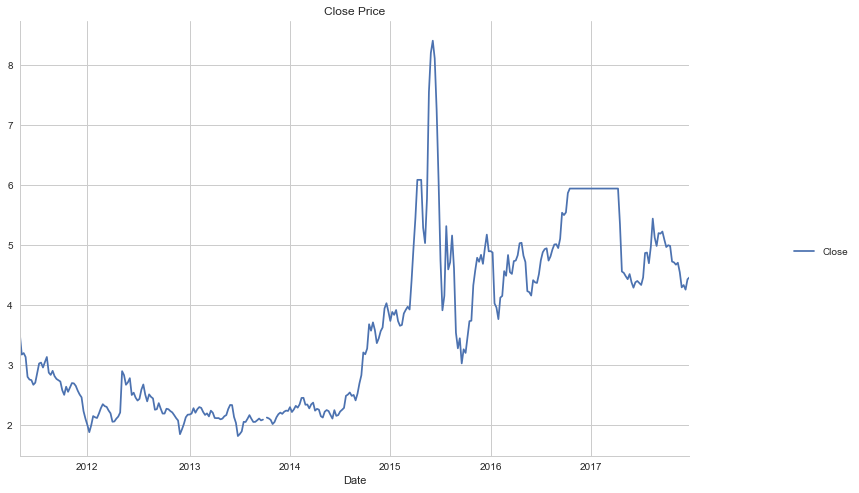

In [4]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
stock_train.plot()
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title('Close Price')
sns.despine()

## 一阶差分 

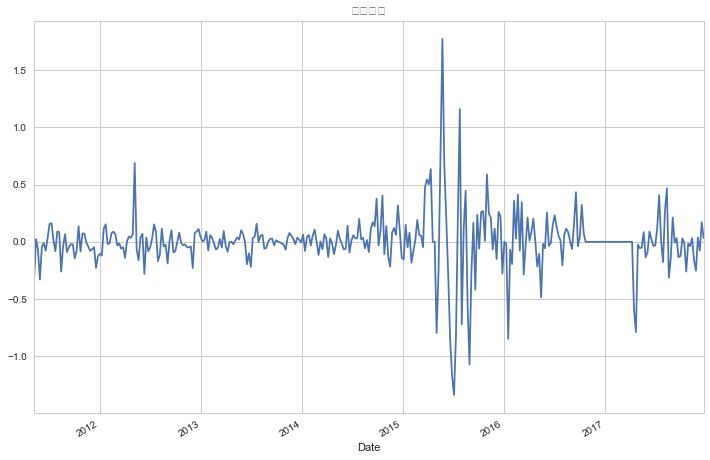

In [5]:
stock_diff = stock_train.diff()
stock_diff = stock_diff.dropna()

plt.figure(figsize=(12,8))

stock_diff.plot()
plt.title(u'一阶差分')
plt.show()

## ACF & PACF

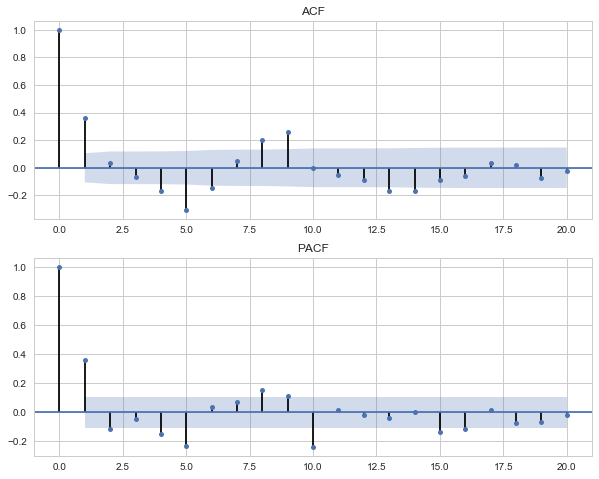

In [44]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(stock_diff, lags=20, ax=ax1)
plt.title('ACF')

ax2 = fig.add_subplot(212)
fig =  plot_pacf(stock_diff, lags=20, ax=ax2)
plt.title('PACF') 

plt.show()
        

**ACF** & **PACF** 一阶差分之后都落到了 0轴上，表示我们只需要一阶差分就好了！

# 时间序列分析--ARIMA模型

指数平滑法对时间序列上连续的值之间的相关性没有要求。但是，如果你想使用指数平滑法计算出预测区间， 那么预测误差必须是不相关的， 且必须是服从零均值、 方差不变的正态分布。即使指数平滑法对时间序列连续数值之间相关性没有要求，**在某种情况下， 我们可以通过考虑数据之间的相关性来创建更好的预测模型**。 
```自回归移动平均模型（ ARIMA）是最常用的时间序列预测模型。```

#### ARIMA模型 
全称为 自回归积分滑动平均模型(Autoregressive Integrated Moving Average Model, 简记ARIMA)，ARIMA(p,d,q)模型是针对非平稳时间序列所建立的模型。 
根据时间序列是否平稳以及回归中所含部分的不同，可分为：
```
移动平均过程（MA（q））

自回归过程（AR（p））

自回归移动平均过程( ARMA(p,q) )

自回归积分滑动平均过程 ( ARIMA(p,d,q) )
```

In [59]:
stock_train = stock_train.dropna()
model = ARIMA(stock_train, order=(6,1,6), freq='W-MON')
model_fit = model.fit(disp=0,maxiter=100)
print(model_fit.summary())


/Users/yongliu/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  346
Model:                 ARIMA(6, 1, 6)   Log Likelihood                  40.223
Method:                       css-mle   S.D. of innovations              0.215
Date:                Fri, 19 Jan 2018   AIC                            -52.445
Time:                        14:48:27   BIC                              1.405
Sample:                    05-09-2011   HQIC                           -31.002
                         - 12-25-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0028      0.014      0.200      0.842      -0.025       0.030
ar.L1.D.Close     0.7996      0.158      5.067      0.000       0.490       1.109
ar.L2.D.Close    -1.0356      0.283     

## 用QQ 图验证是否符合正态分布


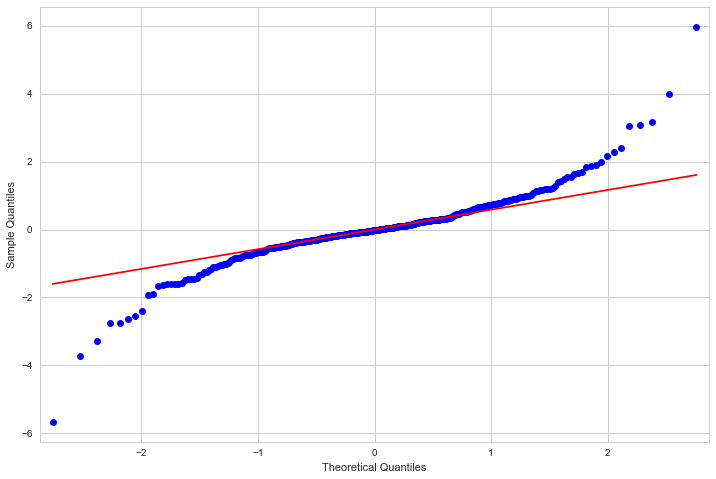

In [58]:
from statsmodels.graphics.api import qqplot
# 残差
resid = model_fit.resid.values
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [38]:
stock_train.tail()

Date
2017-11-27    4.298
2017-12-04    4.336
2017-12-11    4.260
2017-12-18    4.432
2017-12-25    4.464
Freq: W-MON, Name: Close, dtype: float64

In [41]:
pred = model_fit.predict('20171127', '20180502', dynamic=True, typ='levels')
print (pred)

2017-11-27    4.484343
2017-12-04    4.476690
2017-12-11    4.477478
2017-12-18    4.479493
2017-12-25    4.481686
2018-01-01    4.483906
2018-01-08    4.486130
2018-01-15    4.488354
2018-01-22    4.490578
2018-01-29    4.492802
2018-02-05    4.495027
2018-02-12    4.497251
2018-02-19    4.499475
2018-02-26    4.501699
2018-03-05    4.503924
2018-03-12    4.506148
2018-03-19    4.508372
2018-03-26    4.510596
2018-04-02    4.512821
2018-04-09    4.515045
2018-04-16    4.517269
2018-04-23    4.519493
2018-04-30    4.521718
Freq: W-MON, dtype: float64


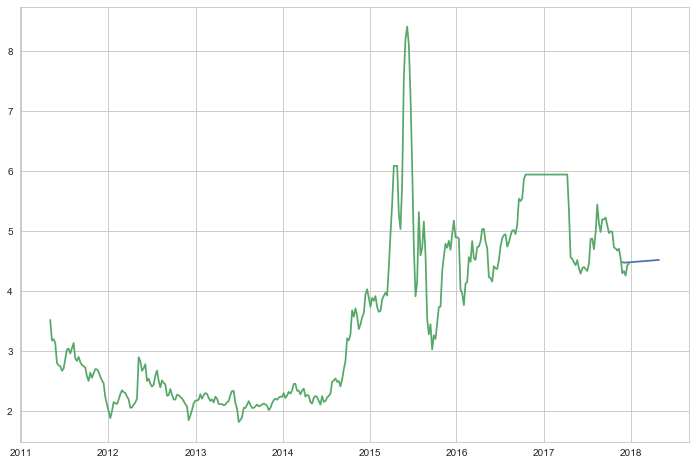

In [60]:
plt.figure(figsize=(12,8))
plt.plot(pred)
plt.plot(stock_train)